In [110]:
import ee
import geopandas as gpd
from rasterio.mask import mask
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import requests
import tempfile
import os

## Para a segunda abordagem vamos precisar de arquivos GeoTif para todos os dias e não apenas anual.

In [2]:
ee.Authenticate(force=True)
service_account = 'pdi-618@projetopdi-430718.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, '../dados/projetopdi-430718-5d4f0b0f6064.json')
ee.Initialize(credentials)


Successfully saved authorization token.


In [65]:
# Carregar o shapefile
gdf = gpd.read_file('../dados/shapefile_estacoes_divididas/estacoes_territorios_dividido.shp')

# Filtrar a região de ID A305
gdf_a305 = gdf[gdf['id_estacao'] == 'A305']

# Converter a geometria do GeoDataFrame para o formato GeoJSON
geometria = gdf_a305.geometry.values[0].__geo_interface__

In [118]:
# Criar o polígono no Google Earth Engine a partir do GeoJSON
aoi = ee.Geometry(geometria)

# Definir o intervalo de datas de interesse
start_date = '2020-01-01'
end_date = '2020-01-27'

# Carregar a coleção Sentinel-1 e filtrar por data
sentinel1_image = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(aoi) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .mean()  # Calcula a média das imagens no período para reduzir ruído

# Selecionar as bandas VV e VH
sentinel1_image = sentinel1_image.select(['VV', 'VH']).clip(aoi)

# Gerar URL de download direto
url = sentinel1_image.getDownloadURL({
    'scale': 70,  # Resolução espacial do Sentinel-1 (10 metros)
    'region': aoi.getInfo()['coordinates'],
    'format': 'GeoTIFF'
})

# Imprimir a URL de download
print("Download URL:", url)

Download URL: https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/1eba7b92bb8e3de43f7f5d26d2972e08-7c131dddffb52f846ef118a25dd18633:getPixels


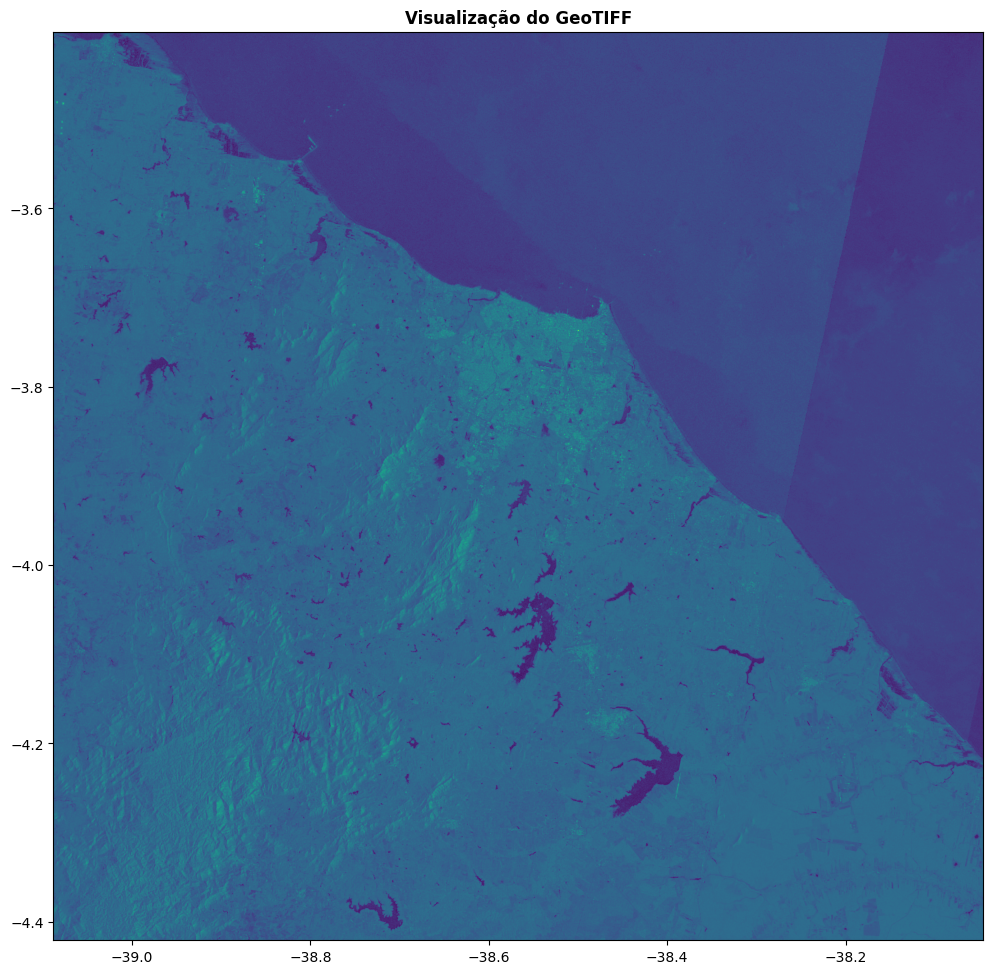

In [119]:
# Fazer o download do GeoTIFF
response = requests.get(url)
response.raise_for_status()  # Verificar se o download foi bem-sucedido

# Criar um arquivo temporário para salvar o GeoTIFF
with tempfile.NamedTemporaryFile(delete=False, suffix='.tif') as tmp_file:
    tmp_file.write(response.content)
    tmp_path = tmp_file.name

# Abrir e exibir o arquivo GeoTIFF
with rasterio.open(tmp_path) as src:
    # Configurar o tamanho da figura (exemplo: 12x12 polegadas)
    plt.figure(figsize=(12, 12))
    
    # Exibir o arquivo usando rasterio
    show(src, title="Visualização do GeoTIFF")

    # Mostrar a imagem plotada
    plt.show()

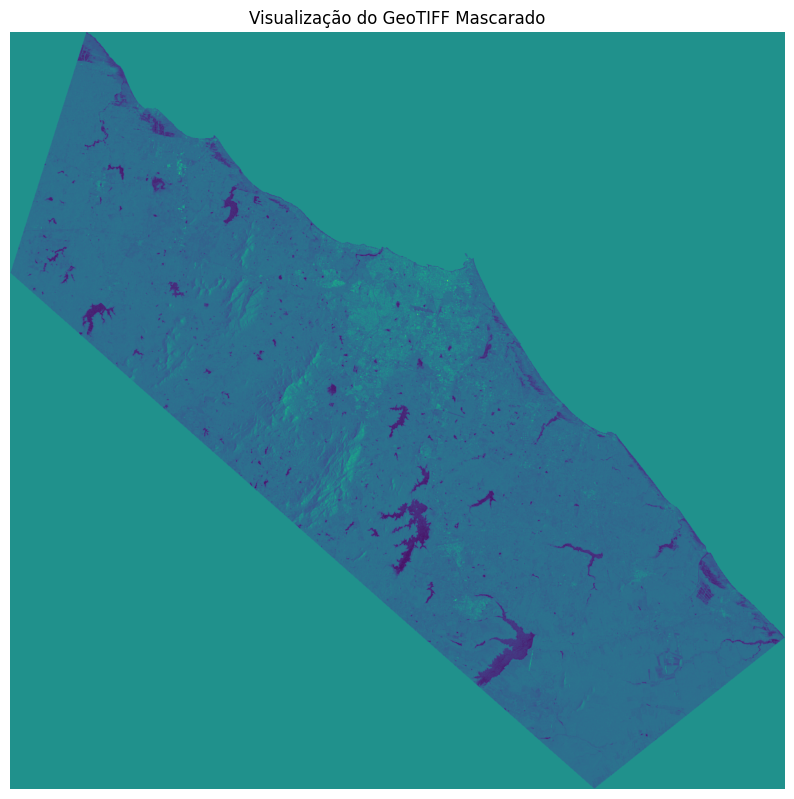

In [117]:
# Obter a geometria do polígono da região filtrada e convertê-la para o formato GeoJSON
geometries = [gdf_a305.geometry.iloc[0]]

# Abrir o arquivo GeoTIFF e aplicar a máscara
with rasterio.open(tmp_path) as src:
    out_image, out_transform = mask(src, geometries, crop=True)
    out_meta = src.meta.copy()

# Atualizar os metadados para o novo arquivo mascarado
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Exibir a imagem mascarada
plt.figure(figsize=(10, 10))
plt.imshow(out_image[0], cmap='viridis')
plt.title("Visualização do GeoTIFF Mascarado")
plt.axis('off')
plt.show()

# Excluir o arquivo temporário
os.remove(tmp_path)

 Método de Segmentação:
Para segmentação de vegetação e corpos d'água, pode ser útil usar métodos de aprendizado de máquina, como Random Forest, em vez de apenas trabalhar com os dados brutos de radar. Para isso, você pode combinar as bandas VV e VH com índices derivados (como NDVI de Sentinel-2) e treinar um modelo.